-  from Mel0711D2__se_resnext50_32x4dSZ224_newFrmwrk_newestcode
- B2SZ384
- OneCycle
- starting from FLD1

# start

In [1]:
class Param: pass
param = Param()

#########################
param.PRFX = 'Mel0713A2'#
#########################

param.PRFX_B4 = None; param.FLD2USE_B4 = 0
param.PRFX_PREP = 'MelPrp0909B384' 
param.ARCH = 'efficientnet-b2'

from efficientnet_pytorch import EfficientNet
param.SZ = 384 

param.EPOCHS = 10

param.BS = 72
param.SEED = 101; 

param.K=5; 
param.FLDS2USE = range(1, param.K)
param.FP16 = True
param.PLTFACTOR=0.5; param.PATIENCE=5; param.MIN_LR=1e-8

param.USE_LAST_M_EPCS = 5

param.RandomResizedCrop_scale=(0.75, 1.0)
param.N_TTA = 8

param.LR=1e-3
param.WD=0

param.N_SAMPL = None

param.DEBUG = False
if param.DEBUG: 
    param.EPOCHS = 2
    param.FLDS2USE = [0,1]
    param.N_SAMPL = 1024

DEVICE = 'cuda'; 
if DEVICE=='cpu': param.FP16 = False
PIN_MEM = (DEVICE=='cuda'); N_WORKERS=4

param.__dict__

{'PRFX': 'Mel0713A2',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0909B384',
 'ARCH': 'efficientnet-b2',
 'SZ': 384,
 'EPOCHS': 10,
 'BS': 72,
 'SEED': 101,
 'K': 5,
 'FLDS2USE': range(1, 5),
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'USE_LAST_M_EPCS': 5,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'N_TTA': 8,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [2]:
!nvidia-smi

Mon Jul 13 18:18:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   48C    P0    28W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [3]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

import pretrainedmodels
# from efficientnet_pytorch import EfficientNet
import cv2
import albumentations as A
from albumentations import pytorch as AT

from apex import amp

import warnings; warnings.filterwarnings("ignore")


def sigmoid(x): return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(param.SEED)



p_out = f'../output/{param.PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'
if param.PRFX_B4 is not None: p_b4  = f'../output/{param.PRFX_B4}'


# prep

In [4]:
p_prp = f'../output/{param.PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 
print(dftrn.shape)

set_seed(param.SEED); dftrn = dftrn.sample(frac=1.)

if param.N_SAMPL is not None: dftrn = dftrn.head(param.N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(58032, 4)


,source,im_pth,patient_id,target
23539,20,../output/MelPrp0909B384/siim-isic-melanoma-cl...,IP_2618037,0.0
48725,19,../output/MelPrp0909B384/andrewmvd--isic-2019/...,BCN_0000529,0.0


(58032, 4)

20    32701
19    25331
Name: source, dtype: int64

source
19    0.178516
20    0.017767
Name: target, dtype: float64

## folds

In [5]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

2084


In [6]:
set_seed(param.SEED)
kf = GroupKFold(n_splits=param.K)
fld2trvl=list(kf.split(dftrn, groups=dftrn.patient_id))

for fld, (tr, vl) in enumerate(fld2trvl):
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())

0 46425 11607
1 46425 11607
2 46426 11606
3 46426 11606
4 46426 11606


0.0    0.912159
1.0    0.087841
Name: target, dtype: float64

0.0    0.911922
1.0    0.088078
Name: target, dtype: float64

0.0    0.911903
1.0    0.088097
Name: target, dtype: float64

0.0    0.910697
1.0    0.089303
Name: target, dtype: float64

0.0    0.913648
1.0    0.086352
Name: target, dtype: float64

20    26172
19    20253
Name: source, dtype: int64

20    26147
19    20278
Name: source, dtype: int64

20    26171
19    20255
Name: source, dtype: int64

20    26137
19    20289
Name: source, dtype: int64

20    26177
19    20249
Name: source, dtype: int64

In [7]:
display(dftrn.source.value_counts())
idx20 = np.where(dftrn.source==20)[0]
len(idx20)

20    32701
19    25331
Name: source, dtype: int64

32701

In [8]:
fld2vl20 = []
for tr, vl in fld2trvl:
    vl20 = np.array([o for o in vl if o in idx20])
    print(len(vl), len(vl20))
    fld2vl20.append(vl20)

11607 6529
11607 6554
11606 6530
11606 6564
11606 6524


## testset

In [9]:
dftst = pd.read_csv(f'{p_prp}/test.csv', nrows=128 if param.DEBUG else None) 
display(dftst.head(3))

dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv', nrows=128 if param.DEBUG else None) 

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../output/MelPrp0909B384/siim-isic-melanoma-cl...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../output/MelPrp0909B384/siim-isic-melanoma-cl...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../output/MelPrp0909B384/siim-isic-melanoma-cl...


# dataset

In [10]:
class MelDataset(Dataset):
    def __init__(self, df, mode='trn'):
        self.df = df
        self.mode = mode
        if mode=='trn':
            self.composed = A.Compose([
                A.RandomResizedCrop(param.SZ,param.SZ, scale=param.RandomResizedCrop_scale),
                A.Transpose(),
                A.Flip(),
                A.Rotate(360),
                A.OneOf([A.RandomBrightnessContrast(), A.CLAHE(),]),
                A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5),
                A.Normalize(), 
                AT.ToTensor(),
            ])    
        else:
            self.composed = A.Compose([
                A.Resize(param.SZ, param.SZ),
                A.Normalize(),
                AT.ToTensor(),
            ])    
    def __getitem__(self, i):
        x = cv2.imread(self.df.im_pth.values[i]) 
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = self.composed(image=x)['image']
        if self.mode in ('trn', 'val'):
            y = self.df.target.values[i]
            return x, y
        else:
            return (x,)
    
    def __len__(self):
        return len(self.df)    

In [11]:
# better comment out A.Normalize() when showing 
if param.DEBUG:
    dstrn = MelDataset(dftrn, mode='trn')
    i = np.random.choice(len(dstrn))
    print(dstrn[i][0].shape)
    plt.imshow(dstrn[i][0].permute(1, 2, 0))

## test ds

In [12]:
dstst = MelDataset(dftst, mode='tst')
print(len(dstst))
dltst = DataLoader(dstst, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltst))
lendl=len(dltst)

10982
77


# model

In [13]:
def mkmdl():  
    mdl = EfficientNet.from_pretrained(param.ARCH, num_classes=1)
    return mdl

In [14]:
mdl = mkmdl()

Loaded pretrained weights for efficientnet-b2


## focal loss

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=3, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

def loss_fn(outputs, targets):
    return FocalLoss()(outputs, targets.view(-1, 1))

# train

## TTA

In [16]:
# def evaluate(model, dl):
#     model.eval()
#     prd = []
#     y = []
#     for step, dat in enumerate(dl):
#         xb, yb = (o.to(device) for o in dat)
#         with torch.no_grad(): prdb = model(xb)
#         prd.append(prdb.cpu().detach().numpy())
#         y.append(yb.cpu().detach().numpy())
#     prd = np.concatenate(prd)    
#     y = np.concatenate(y)    
#     lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
#     scr = roc_auc(y, prd)
#     return lss, scr, y, prd

In [17]:
# Diheral TTA outside dataloader
def get_trans(img, I):
    if I >= 4:
        img = img.transpose(2,3)
    if I % 4 == 0:
        return img
    elif I % 4 == 1:
        return img.flip(2)
    elif I % 4 == 2:
        return img.flip(3)
    elif I % 4 == 3:
        return img.flip(2).flip(3)

In [18]:
def evaluate(model, dl):
    model.eval()
    prd = []
    y = []   
    for step, dat in enumerate(dl):
        xb, yb = (o.to(device) for o in dat)
        y.append(yb.cpu().detach().numpy())
        with torch.no_grad(): 
            for I in range(param.N_TTA):
                if I==0: 
                    prdb = model(get_trans(xb, I))
                else:
                    prdb += model(get_trans(xb, I))    
        prd.append((prdb/param.N_TTA).cpu().detach().numpy())
    prd = np.concatenate(prd)    
    y = np.concatenate(y)    
    lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
    scr = roc_auc(y, prd)
    return lss, scr, y, prd

## infer

In [19]:
def infer(model, dl):
    lendl=len(dl)
    model.eval()
    prd = []
    for step, dat in enumerate(dl):
        if step>0 and step%1000==0: print(dtnow(), f'step {step}/{lendl}')
        xb=dat[0].to(device)
        with torch.no_grad(): 
            for I in range(param.N_TTA):
                if I==0: 
                    prdb = model(get_trans(xb, I))
                else:
                    prdb += model(get_trans(xb, I))    
        prd.append((prdb/param.N_TTA).cpu().detach().numpy())
    prd = np.concatenate(prd)    

    return prd

## set up data

In [20]:
def getdls(fld):
    tr,vl=fld2trvl[fld]
    vl20 =fld2vl20[fld]
    assert set(vl20) < set(vl)
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    dfvl20=dftrn.iloc[vl20]
    ystr=dftr.target.values
    ysvl=dfvl.target.values
    ysvl20=dfvl20.target.values
    dstr = MelDataset(dftr, mode='trn')
    dsvl = MelDataset(dfvl, mode='val')
    dsvl20 = MelDataset(dfvl20, mode='val')
    dltr = DataLoader(dstr, batch_size=param.BS,       shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
    dlvl = DataLoader(dsvl, batch_size=param.BS*2,     shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
    dlvl20 = DataLoader(dsvl20, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
    lendl=len(dltr)    
    return dltr,dlvl,dlvl20

## run train

In [21]:
set_seed(param.SEED)

results = {}
results['fld2trvl'] = fld2trvl
results['fld2vl20'] = fld2vl20
results['param'] = param
results['fld2stats']={}

for fld in param.FLDS2USE:
    
    tr,vl=fld2trvl[fld]
    dltr,dlvl,dlvl20=getdls(fld)
    print(f'fld:{fld};', 'dltr,dlvl,dlvl20:', len(dltr), len(dlvl),len(dlvl20))

    mdl = mkmdl().to(device)
    if param.PRFX_B4 is not None: 
        fnm_mdl_b4 = f'{p_b4}/model_{param.PRFX_B4}_fld_{param.fld}_best.p'
        print('load previously trained', fnm_mdl_b4)
        mdl.load_state_dict(torch.load(fnm_mdl_b4, map_location=torch.device(DEVICE)))
    # opt = optim.SGD(mdl.parameters(), lr=param.LR, momentum=param.MOMENTUM, weight_decay=param.WD)
    opt = optim.Adam(mdl.parameters(), lr=param.LR, weight_decay=param.WD)
#     schdl = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=param.PLTFACTOR, patience=param.PATIENCE, min_lr=param.MIN_LR, verbose=True)
    schdl = optim.lr_scheduler.OneCycleLR(opt, max_lr=param.LR, total_steps=param.EPOCHS*len(dltr))
    if param.FP16: mdl, opt = amp.initialize(mdl, opt, opt_level='O1', verbosity=0)
    mdl.zero_grad()

        

    stats = {
    'lss': {'tr':[],'vl':[],'vl20':[]},
    'scr': {'tr':[],'vl':[],'vl20':[]},
    }
    ep2oof = []

    best_scr = float('-inf')
    best_epc = -1
    best_scr20 = float('-inf')
    best_epc20 = -1
    
    
    for epc in range(param.EPOCHS):
        prdtr_ep=[]
        ytr_ep=[]
        for step, dat in enumerate(dltr):
            mdl.train()
            xb,yb=(o.to(device) for o in dat)
            yb = yb.unsqueeze(1)
            prdb = mdl(xb)
    #         loss = F.binary_cross_entropy_with_logits(prdb, yb)
            loss =  loss_fn(prdb,yb)
            if param.FP16:
                with amp.scale_loss(loss, opt) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            if param.FP16:
                torch.nn.utils.clip_grad_norm_(amp.master_params(opt), 1)
            else:
                torch.nn.utils.clip_grad_norm_(mdl.parameters(), 1)
            opt.step()
            opt.zero_grad()
            prdtr_ep.append(prdb.cpu().detach().numpy())
            ytr_ep.append(yb.cpu().detach().numpy())
            if step>0 and step%1000==0: print(dtnow(), f'ep {epc} step {step}/{lendl}')

        prdtr_ep = np.concatenate(prdtr_ep)
        ytr_ep = np.concatenate(ytr_ep)    
        lss_tr_ep = F.binary_cross_entropy_with_logits(torch.tensor(prdtr_ep),torch.tensor(ytr_ep)).item()
        scr_tr_ep = roc_auc(ytr_ep, prdtr_ep)
        stats['lss']['tr'].append(lss_tr_ep)
        stats['scr']['tr'].append(scr_tr_ep)

        lss_vl_ep, scr_vl_ep, yvl_ep, prdvl_ep = evaluate(mdl, dlvl)
        stats['lss']['vl'].append(lss_vl_ep)
        stats['scr']['vl'].append(scr_vl_ep)
        ep2oof.append(prdvl_ep)

        lss_vl20_ep, scr_vl20_ep, yvl20_ep, prdvl20_ep = evaluate(mdl, dlvl20)
        stats['lss']['vl20'].append(lss_vl20_ep)
        stats['scr']['vl20'].append(scr_vl20_ep)

        print(dtnow(), f'fld {fld} ep {epc}: lss_tr {lss_tr_ep:.3f}; lss_vl {lss_vl_ep:.3f}; lss_vl20 {lss_vl20_ep:.3f}; scr_tr {scr_tr_ep:.3f}; scr_vl {scr_vl_ep:.3f}; scr_vl20 {scr_vl20_ep:.3f}; ')

        if epc> (5 if not param.DEBUG else -1):
            prdtst = infer(mdl, dltst)
            dfsub.target = sigmoid(prdtst)
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv', index=False)
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_epc_{epc}.p')

        if scr_vl_ep>best_scr:
            print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
            best_scr = scr_vl_ep
            best_epc = epc
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_best.p')
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best.csv', index=False)

        if scr_vl20_ep>best_scr20:
            print(f'better scr20 {best_scr20:.3f} -> {scr_vl20_ep:.3f}')
            best_scr20 = scr_vl20_ep
            best_epc20 = epc
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_best20.p')
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best20.csv', index=False)

        schdl.step(scr_vl_ep)  # Update learning rate schedule
        
        stats['best_scr'] = best_scr
        stats['best_epc'] = best_epc
        stats['best_scr20'] = best_scr20
        stats['best_epc20'] = best_epc20
        results['fld2stats'][fld] = stats
        pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  
    pickle.dump(ep2oof, open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'wb'))  

fld:1; dltr,dlvl,dlvl20: 645 81 46
Loaded pretrained weights for efficientnet-b2
2020-07-13 18:27:38 fld 1 ep 0: lss_tr 0.394; lss_vl 0.331; lss_vl20 0.233; scr_tr 0.845; scr_vl 0.903; scr_vl20 0.866; 
better scr -inf -> 0.903
better scr20 -inf -> 0.866
2020-07-13 18:36:55 fld 1 ep 1: lss_tr 0.345; lss_vl 0.325; lss_vl20 0.227; scr_tr 0.900; scr_vl 0.912; scr_vl20 0.880; 
better scr 0.903 -> 0.912
better scr20 0.866 -> 0.880
2020-07-13 18:46:12 fld 1 ep 2: lss_tr 0.328; lss_vl 0.327; lss_vl20 0.239; scr_tr 0.918; scr_vl 0.917; scr_vl20 0.888; 
better scr 0.912 -> 0.917
better scr20 0.880 -> 0.888
2020-07-13 18:55:30 fld 1 ep 3: lss_tr 0.316; lss_vl 0.296; lss_vl20 0.206; scr_tr 0.928; scr_vl 0.921; scr_vl20 0.882; 
better scr 0.917 -> 0.921
2020-07-13 19:04:48 fld 1 ep 4: lss_tr 0.301; lss_vl 0.280; lss_vl20 0.185; scr_tr 0.938; scr_vl 0.922; scr_vl20 0.894; 
better scr 0.921 -> 0.922
better scr20 0.888 -> 0.894
2020-07-13 19:14:05 fld 1 ep 5: lss_tr 0.289; lss_vl 0.253; lss_vl20 0.157

In [22]:
pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  

# training trajec

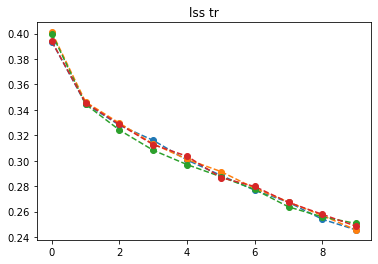

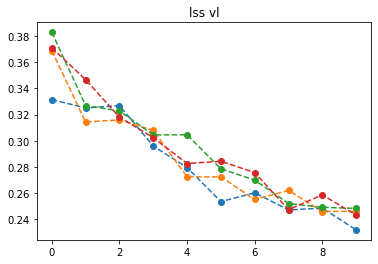

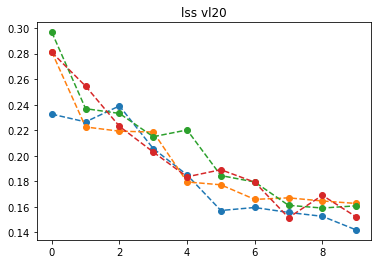

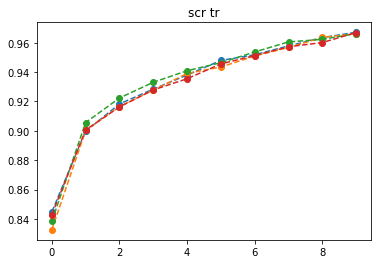

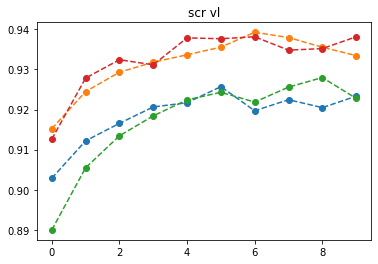

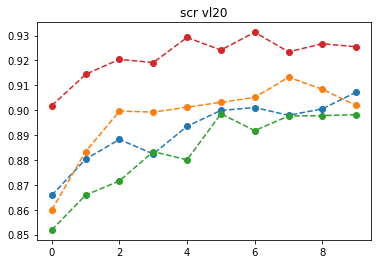

In [23]:
for mtrc in ['lss', 'scr']:
    for k in ['tr','vl','vl20']:
        plt.title(f'{mtrc} {k}')
        for fld in param.FLDS2USE:
            plt.plot(results['fld2stats'][fld][mtrc][k], 'o--')
        plt.show()

# oofs

In [24]:
vls = []
for fld in param.FLDS2USE:
    _,vl=fld2trvl[fld]
    vls += list(vl)
len(vls), vls[:10]

(46425, [7, 8, 11, 18, 23, 37, 45, 50, 53, 58])

## only last epoch 

In [25]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:,-1])
    oofs += list(oof)
    
roc_auc(dftrn.target.iloc[vls], oofs)

0.9290619440614258

In [26]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

IndexError: index 46425 is out of bounds for axis 0 with size 46425

## only best_scr epoch

In [27]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    best_epc = results['fld2stats'][fld]['best_epc']
    oof = list(ep2oof[:,best_epc])
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9323177320591675

In [28]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

IndexError: index 46425 is out of bounds for axis 0 with size 46425

## only best_scr20 epoch

In [29]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    best_epc = results['fld2stats'][fld]['best_epc20']
    oof = list(ep2oof[:,best_epc])
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9289156973528672

In [30]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

IndexError: index 46425 is out of bounds for axis 0 with size 46425

## avg all epochs

In [31]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof.mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9335696207932378

In [32]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

IndexError: index 46425 is out of bounds for axis 0 with size 46425

## avg last m epochs

In [33]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:, -3:].mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.932678567170348

In [34]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

IndexError: index 46425 is out of bounds for axis 0 with size 46425

In [35]:
def get_oof_avg_last_m(m):
    oofs = []
    for fld in param.FLDS2USE:
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
        ep2oof = np.concatenate(ep2oof,1)
        oof = list(ep2oof[:, -m:].mean(1))
        oofs += list(oof)
    return oofs

In [36]:
for m in range(1, 5):
    oofs = get_oof_avg_last_m(m)
    oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
    print(m, f'{roc_auc(dftrn.target.iloc[vls], oofs):.3f}', 
          f'{roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20]):.3f}')


IndexError: index 46425 is out of bounds for axis 0 with size 46425

## avg last m epochs before epo-q

In [37]:
def get_oof_avg_last_m_before_q(m,q):
    oofs = []
    for fld in param.FLDS2USE:
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
        ep2oof = np.concatenate(ep2oof,1)
        oof = list(ep2oof[:, q-m:q].mean(1))
        oofs += list(oof)
    return oofs

In [38]:
for m in range(1, 5):
    oofs = get_oof_avg_last_m_before_q(m, 10)
    oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
    print(m, f'{roc_auc(dftrn.target.iloc[vls], oofs):.3f}', 
          f'{roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20]):.5f}')


IndexError: index 46425 is out of bounds for axis 0 with size 46425

# submissions

## only last epoch

In [39]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{param.EPOCHS-1}.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 1 0.13051890358658727


,image_name,target
0,ISIC_0052060,0.093844
1,ISIC_0052349,0.058453
2,ISIC_0058510,0.035544


fld 2 0.14706236688689675


,image_name,target
0,ISIC_0052060,0.097048
1,ISIC_0052349,0.036288
2,ISIC_0058510,0.019494


fld 3 0.13443750028337276


,image_name,target
0,ISIC_0052060,0.048316
1,ISIC_0052349,0.045016
2,ISIC_0058510,0.020844


fld 4 0.1374944567921873


,image_name,target
0,ISIC_0052060,0.058561
1,ISIC_0052349,0.058132
2,ISIC_0058510,0.012007


0.13737830688726096


,image_name,target
0,ISIC_0052060,0.074442
1,ISIC_0052349,0.049472
2,ISIC_0058510,0.021972


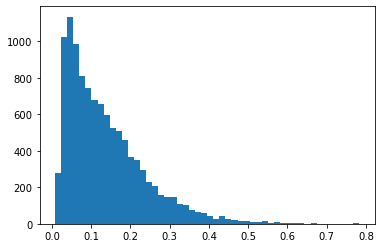

In [40]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [41]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlylast.csv', index=False)

## only best_scr epoch

In [42]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 1 0.0


,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0


fld 2 0.1581931502442629


,image_name,target
0,ISIC_0052060,0.113187
1,ISIC_0052349,0.109325
2,ISIC_0058510,0.026607


fld 3 0.14082676667892877


,image_name,target
0,ISIC_0052060,0.092033
1,ISIC_0052349,0.049959
2,ISIC_0058510,0.028275


fld 4 0.16907000855062826


,image_name,target
0,ISIC_0052060,0.087252
1,ISIC_0052349,0.066812
2,ISIC_0058510,0.025957


0.11702248136845518


,image_name,target
0,ISIC_0052060,0.073118
1,ISIC_0052349,0.056524
2,ISIC_0058510,0.020210


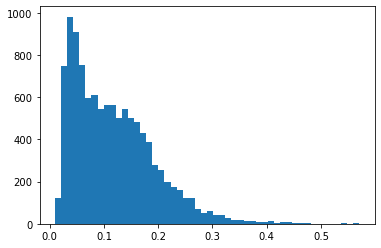

In [43]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [44]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlybestscr.csv', index=False)

## only best_scr20 epoch

In [45]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best20.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 1 0.13051890358658727


,image_name,target
0,ISIC_0052060,0.093844
1,ISIC_0052349,0.058453
2,ISIC_0058510,0.035544


fld 2 0.16040407022555145


,image_name,target
0,ISIC_0052060,0.141756
1,ISIC_0052349,0.089933
2,ISIC_0058510,0.015425


fld 3 0.14706236688689675


,image_name,target
0,ISIC_0052060,0.097048
1,ISIC_0052349,0.036288
2,ISIC_0058510,0.019494


fld 4 0.16907000855062826


,image_name,target
0,ISIC_0052060,0.087252
1,ISIC_0052349,0.066812
2,ISIC_0058510,0.025957


0.15176383731241577


,image_name,target
0,ISIC_0052060,0.104975
1,ISIC_0052349,0.062872
2,ISIC_0058510,0.024105


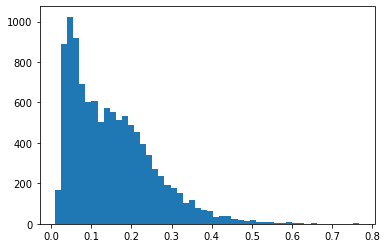

In [46]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [47]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlybestscr20.csv', index=False)

## avg last m epochs

In [48]:
m = 3

In [49]:
lst_sub = []
for fld in param.FLDS2USE:
    for epc in range(param.EPOCHS-m, param.EPOCHS):
        sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv') 
        print('fld', fld, 'epc', epc, sub_fld.target.mean())
        display(sub_fld.head(3))
        lst_sub.append(sub_fld.target.values)

fld 1 epc 7 0.14232526639455464


,image_name,target
0,ISIC_0052060,0.118385
1,ISIC_0052349,0.053403
2,ISIC_0058510,0.045184


fld 1 epc 8 0.14074125935346904


,image_name,target
0,ISIC_0052060,0.148294
1,ISIC_0052349,0.059102
2,ISIC_0058510,0.037679


fld 1 epc 9 0.13051890358658727


,image_name,target
0,ISIC_0052060,0.093844
1,ISIC_0052349,0.058453
2,ISIC_0058510,0.035544


fld 2 epc 7 0.16040407022555145


,image_name,target
0,ISIC_0052060,0.141756
1,ISIC_0052349,0.089933
2,ISIC_0058510,0.015425


fld 2 epc 8 0.1550350400254772


,image_name,target
0,ISIC_0052060,0.132402
1,ISIC_0052349,0.092196
2,ISIC_0058510,0.020567


fld 2 epc 9 0.14706236688689675


,image_name,target
0,ISIC_0052060,0.097048
1,ISIC_0052349,0.036288
2,ISIC_0058510,0.019494


fld 3 epc 7 0.14174193187374778


,image_name,target
0,ISIC_0052060,0.062560
1,ISIC_0052349,0.066206
2,ISIC_0058510,0.040617


fld 3 epc 8 0.14082676667892877


,image_name,target
0,ISIC_0052060,0.092033
1,ISIC_0052349,0.049959
2,ISIC_0058510,0.028275


fld 3 epc 9 0.13443750028337276


,image_name,target
0,ISIC_0052060,0.048316
1,ISIC_0052349,0.045016
2,ISIC_0058510,0.020844


fld 4 epc 7 0.13996949185430607


,image_name,target
0,ISIC_0052060,0.063482
1,ISIC_0052349,0.058885
2,ISIC_0058510,0.021045


fld 4 epc 8 0.15198348841577106


,image_name,target
0,ISIC_0052060,0.088662
1,ISIC_0052349,0.055209
2,ISIC_0058510,0.033086


fld 4 epc 9 0.1374944567921873


,image_name,target
0,ISIC_0052060,0.058561
1,ISIC_0052349,0.058132
2,ISIC_0058510,0.012007


0.14354504519757103


,image_name,target
0,ISIC_0052060,0.095445
1,ISIC_0052349,0.060232
2,ISIC_0058510,0.027481


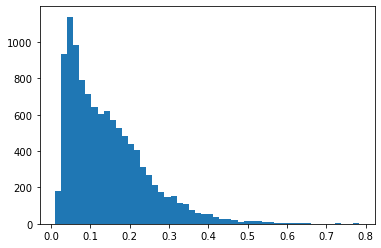

In [50]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [51]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_avglast{m}.csv', index=False)

## avg last m epochs before epo-q

In [52]:
m = 2
q = 13

In [53]:
lst_sub = []
for fld in param.FLDS2USE:
    for epc in range(q-m, q):
        sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv') 
        print('fld', fld, 'epc', epc, sub_fld.target.mean())
        display(sub_fld.head(3))
        lst_sub.append(sub_fld.target.values)

FileNotFoundError: [Errno 2] File ../output/Mel0713A2/submission_Mel0713A2_fld_1_epc_11.csv does not exist: '../output/Mel0713A2/submission_Mel0713A2_fld_1_epc_11.csv'

nan


,image_name,target
0,ISIC_0052060,NaN
1,ISIC_0052349,NaN
2,ISIC_0058510,NaN


ValueError: autodetected range of [nan, nan] is not finite

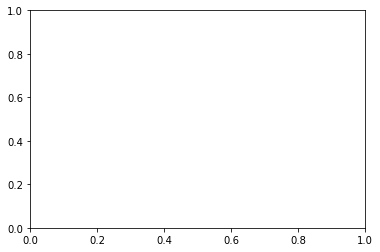

In [54]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [55]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_{m}before{q}.csv', index=False)

# fin

In [56]:
param.__dict__

{'PRFX': 'Mel0713A2',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0909B384',
 'ARCH': 'efficientnet-b2',
 'SZ': 384,
 'EPOCHS': 10,
 'BS': 72,
 'SEED': 101,
 'K': 5,
 'FLDS2USE': range(1, 5),
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'USE_LAST_M_EPCS': 5,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'N_TTA': 8,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [57]:
!nvidia-smi

Tue Jul 14 01:21:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   44C    P0    43W / 300W |  16157MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  